## Greedy feature selection

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv('penguins_size.csv')
df.loc[df[df['sex']=='.'].index, 'sex'] = np.nan

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
# 3つ以上値を持っていないレコードを削除
df.dropna(thresh=3, inplace=True)

In [34]:
X = df.drop('species', axis=1)
y = df['species']

# fill_valueで欠損値を置換
imputer = SimpleImputer(strategy='constant', fill_value='NaN')
imputer.set_output(transform='pandas')
X['sex'] = imputer.fit_transform(X[['sex']])

# one-hot-encording
class GetDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)

# 特徴量エンジニアリング
poly = PolynomialFeatures(degree=2, include_bias=False)
X[['culmen_length_mm', 'culmen_depth_mm', 'culmen_length_mm^2', 'culmen_length_mm * culmen_depth_mm', 'culmen_depth_mm^2']] = poly.fit_transform(X[['culmen_length_mm', 'culmen_depth_mm']])
# 四則演算
X['culmen_diff'] = X['culmen_length_mm'] - X['culmen_depth_mm']
X['culmen_ratio'] = X['culmen_length_mm'] / X['culmen_depth_mm']

# Pipeline
pipeline = Pipeline([('dummy', GetDummies()),
          ('scaler', StandardScaler()),
          ('model', LogisticRegression())])

#cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)

# Greedy feature selection
gfs = GreedyFeatureSelection(pipeline=pipeline, cv=cv)
gfs.select_feature(X, y)


greedy selection started
island started
['island'] started
best score updated 0 -> 0.7076023391812866
culmen_length_mm started
['culmen_length_mm'] started
best score updated 0.7076023391812866 -> 0.7514619883040936
culmen_depth_mm started
['culmen_depth_mm'] started
best score updated 0.7514619883040936 -> 0.7573099415204679
flipper_length_mm started
['flipper_length_mm'] started
best score updated 0.7573099415204679 -> 0.7982456140350876
body_mass_g started
['body_mass_g'] started
sex started
['sex'] started
culmen_length_mm^2 started
['culmen_length_mm^2'] started
culmen_length_mm * culmen_depth_mm started
['culmen_length_mm * culmen_depth_mm'] started
culmen_depth_mm^2 started
['culmen_depth_mm^2'] started
culmen_diff started
['culmen_diff'] started
best score updated 0.7982456140350876 -> 0.8187134502923977
culmen_ratio started
['culmen_ratio'] started
best score updated 0.8187134502923977 -> 0.9619883040935672
===============culmen_ratio is selected ===============
greedy selecti

In [35]:
print(gfs.scores)

[0, 0.9619883040935672, 0.9912280701754387, 0.9970760233918128, 1.0]


In [32]:
gfs.selected_features

['culmen_ratio', 'island', 'culmen_diff', 'body_mass_g']

In [33]:
class GreedyFeatureSelection():
    
    def __init__(self, pipeline, cv):
        self.pipeline = pipeline
        self.cv = cv
        self.selected_features = []
        self.scores = [0]
        
    def select_feature(self, X, y):
        all_features = X.columns
        while True:
            print('greedy selection started')
            best_score = self.scores[-1]
            candidate_feature = None
            for feature in all_features:
                if feature in self.selected_features:
                    continue
                print(f'{feature} started')
                features = self.selected_features + [feature]
                X_train = X[features]
                # 評価
                score = cross_val_score(self.pipeline, X_train, y, cv=self.cv).mean()
                print(f'{features} started')
                if score > best_score:
                    print(f'best score updated {best_score} -> {score}')
                    best_score = score
                    candidate_feature = feature
            
            if candidate_feature is not None:
                print(f'==============={candidate_feature} is selected ===============')
                self.scores.append(best_score)
                self.selected_features.append(candidate_feature)
            else:
                break

## RFE

In [39]:
rfe = RFE(DecisionTreeClassifier(), n_features_to_select=6)
X = pd.get_dummies(X, drop_first=True)
rfe.fit(X, y)
rfe.transform(X)

array([[20.4       ,  2.09090909,  0.        ,  1.        ,  1.        ,
         0.        ],
       [22.1       ,  2.27011494,  0.        ,  1.        ,  0.        ,
         0.        ],
       [22.3       ,  2.23888889,  0.        ,  1.        ,  0.        ,
         0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ,  0.        ,  1.        ,
         0.        ],
       [30.4       ,  3.05405405,  0.        ,  0.        ,  0.        ,
         0.        ],
       [33.8       ,  3.09937888,  0.        ,  0.        ,  1.        ,
         0.        ]])

In [41]:
rfe.ranking_

array([8, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1])

In [43]:
rfe.feature_names_in_[rfe.support_]

array(['culmen_diff', 'culmen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_NaN'], dtype=object)

In [44]:
Pipeline([('rfe', rfe), ('scaler', StandardScaler()), ('model', LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv)
print(scores)

[0.99122807 0.99122807 1.        ]


In [47]:
# RFECV
rfecv = RFECV(DecisionTreeClassifier(), cv=cv)
rfecv.fit(X, y)
rfecv.transform(X)

array([[20.4       ,  2.09090909,  0.        ],
       [22.1       ,  2.27011494,  0.        ],
       [22.3       ,  2.23888889,  0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ],
       [30.4       ,  3.05405405,  0.        ],
       [33.8       ,  3.09937888,  0.        ]])

In [48]:
rfecv.feature_names_in_[rfecv.support_]

array(['culmen_diff', 'culmen_ratio', 'island_Dream'], dtype=object)

<ErrorbarContainer object of 3 artists>

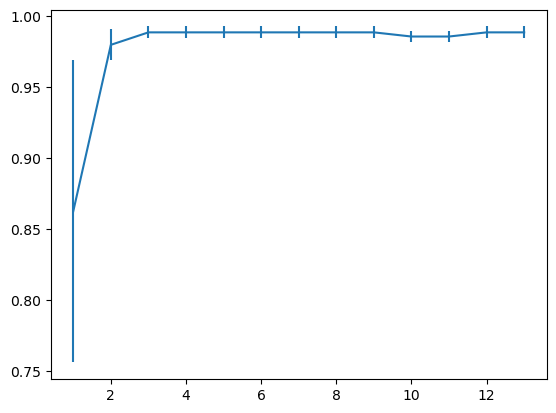

In [51]:
# rfecv.cv_results_
plt.errorbar(range(1, 1+len(rfecv.cv_results_['mean_test_score'])),
             rfecv.cv_results_['mean_test_score'],
             yerr=rfecv.cv_results_['std_test_score'])

In [52]:
rfecv.cv_results_['mean_test_score']

array([0.8625731 , 0.97953216, 0.98830409, 0.98830409, 0.98830409,
       0.98830409, 0.98830409, 0.98830409, 0.98830409, 0.98538012,
       0.98538012, 0.98830409, 0.98830409])

## モデルの係数や重要度で特徴量選択

In [54]:
sfm = SelectFromModel(RandomForestClassifier(random_state=0))
X_selected = sfm.fit_transform(X, y)

In [55]:
X_selected

array([[ 39.1       ,  18.7       , 181.        , ..., 349.69      ,
         20.4       ,   2.09090909],
       [ 39.5       ,  17.4       , 186.        , ..., 302.76      ,
         22.1       ,   2.27011494],
       [ 40.3       ,  18.        , 195.        , ..., 324.        ,
         22.3       ,   2.23888889],
       ...,
       [ 50.4       ,  15.7       , 222.        , ..., 246.49      ,
         34.7       ,   3.21019108],
       [ 45.2       ,  14.8       , 212.        , ..., 219.04      ,
         30.4       ,   3.05405405],
       [ 49.9       ,  16.1       , 213.        , ..., 259.21      ,
         33.8       ,   3.09937888]])

In [56]:
sfm.estimator_.feature_importances_

array([0.08924232, 0.07961904, 0.09933245, 0.0525517 , 0.08072858,
       0.01467092, 0.10925035, 0.14543881, 0.24562145, 0.07424349,
       0.00630753, 0.00299336, 0.        ])

In [57]:
sfm.feature_names_in_[sfm.get_support()]

array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'culmen_length_mm^2', 'culmen_depth_mm^2', 'culmen_diff',
       'culmen_ratio'], dtype=object)

In [58]:
sfm.get_support()

array([ True,  True,  True, False,  True, False,  True,  True,  True,
       False, False, False, False])

## L1正規化項で特徴量選択

In [62]:
SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('feature selection', sfm)])
pipeline.set_output(transform='pandas')
pipeline.fit_transform(X, y)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,culmen_length_mm^2,culmen_depth_mm^2,culmen_diff,culmen_ratio
0,-0.884499,0.785449,-1.418347,-0.893164,0.768371,-1.024588,-1.036429
1,-0.811126,0.126188,-1.062250,-0.827866,0.070068,-0.751183,-0.675598
2,-0.664380,0.430462,-0.421277,-0.695276,0.386112,-0.719018,-0.738471
4,-1.324737,1.089724,-0.563715,-1.270994,1.107627,-1.507068,-1.417695
5,-0.847812,1.748985,-0.777373,-0.860598,1.879435,-1.297994,-1.405186
...,...,...,...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.558654,-1.642135,1.082241,1.690550
340,0.527932,-1.445897,1.003109,0.480563,-1.392157,0.921415,1.343164
341,1.188289,-0.735923,1.501644,1.207312,-0.767211,1.275233,1.217248
342,0.234440,-1.192335,0.789451,0.174842,-1.175658,0.583679,0.902865
